## US Border Patrol Basic Analysis

To do list:
- Make flexible parameters for analysis: (Demographic/sector/nationality)
- Put legends on all plots
- Change integer months to strings for graphs
- Only need past 6 months of forecasting for graphs
- create a ReadME file on how to get this file working from ground zero. Get anaconda, pip install, etc.

CBP Website for reference:  
https://www.cbp.gov/newsroom/stats/southwest-land-border-encounters

### Important:
To get this file to work you must have the following libraries installed:
- pandas
- openpyxl
- seaborn  
  
You must also have the excel file downloaded in the same folder as this notebook  
  
If you are unfamiliar with python here is a guide on pip installing:
- https://docs.python.org/3/installing/index.html  
  
### Inputs

In [1]:
PAST_YEARS = 3   # How many of the past years should be taken into account for the forecastin
GRAPH_YEARS = 5  # How many years should be displayed on graphs

### Importing and Formatting Data

In [2]:
# import the necessary libraries used in the code

import pandas as pd    # for dataframes
import openpyxl        # for reading in excel files
import seaborn as sns  # for nice graphs

In [3]:
# read in the data file
filename = "USBP SBO Encounters by Sector Citiz Group Demo FY13-FY21TD-FEB.xlsx"
df = pd.read_excel(filename, header=6,usecols="B:G", engine='openpyxl')
df.head()

,FY,Month,Sector,Citizenship Grouping,Demographic,Count
0,FY2013,APR,LRT,Mexico,FMUA,70
1,FY2013,AUG,ELC,Mexico,FMUA,10
2,FY2013,AUG,RGV,Mexico,FMUA,186
3,FY2013,AUG,TCA,Mexico,FMUA,136
4,FY2013,DEC,EPT,Mexico,FMUA,30


Switched from strings to integers for months to make calculations easier.  
In order to get the dates to process in the right order, 1=October or the first month in the fiscal year

In [4]:
# months are placed into a list starting with OCT becasue it is the start of the fiscal year,
# which the data uses instead of calendar year.  The months are then mapped to digits starting
# with OCT as 1, NOV as 2, DEC as 3, and so on up to SEP as 12.  Column 'M' is added to the
# dataframe representing the numerical value of the month that was previously assigned. In the
# 'FY' column, the FY is removed from the value so it is represented soley numerically. Changing
# these values to numbers rather than letters or a mix of letters and numbers
# makes it easier to conduct the analysis on the data.
months = ['OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP']
month_map = {month:i+1 for i,month in enumerate(months)}
df["M"] = df["Month"].map(month_map)
df["FY"] = df["FY"].apply(lambda x:int(x[2:6]))
df.head()

,FY,Month,Sector,Citizenship Grouping,Demographic,Count,M
0,2013,APR,LRT,Mexico,FMUA,70,7
1,2013,AUG,ELC,Mexico,FMUA,10,11
2,2013,AUG,RGV,Mexico,FMUA,186,11
3,2013,AUG,TCA,Mexico,FMUA,136,11
4,2013,DEC,EPT,Mexico,FMUA,30,3


In [5]:
df.tail()

,FY,Month,Sector,Citizenship Grouping,Demographic,Count,M
81417,2021,FEB,YUM,All Other,UAC / Single Minors,1,5
81418,2021,FEB,DRT,All Other,UAC / Single Minors,1,5
81419,2021,FEB,DRT,All Other,UAC / Single Minors,1,5
81420,2021,FEB,DRT,All Other,UAC / Single Minors,1,5
81421,2021,FEB,DRT,All Other,UAC / Single Minors,1,5


In [6]:
# data is summed by demographic, fiscal year, and month to consolidate similar data entries into 
# one count.  This way there is one entry for each demographic for every month of each fiscal year
# instead of multiple entries with very similar information.  A new column 'Date' is added to the
# dataframe in order for the user to quickly identify the year and month.
sum_df = df.groupby(["Demographic","FY","M"]).sum().reset_index()
sum_df["Date"] = sum_df["FY"]+sum_df["M"]/100
sum_df

,Demographic,FY,M,Count,Date
0,FMUA,2013,1,799,2013.01
1,FMUA,2013,2,776,2013.02
2,FMUA,2013,3,746,2013.03
3,FMUA,2013,4,847,2013.04
4,FMUA,2013,5,923,2013.05
...,...,...,...,...,...
298,UAC / Single Minors,2021,1,4690,2021.01
299,UAC / Single Minors,2021,2,4476,2021.02
300,UAC / Single Minors,2021,3,4853,2021.03
301,UAC / Single Minors,2021,4,5694,2021.04


### Current Analysis  

- % Change = the (current month - previous month) / previous month
- Predicted = averaging the % Change from the past three years
- Error = The difference between the actual and the predicted totals

In [7]:
# This cell calculates the month to month percent change in data.  After we have aggregated the
# data into one entry for each month, the percent change is calculated by taking the difference
# between the current month and the previous month, then dividing by the previous month's numbers.
# A percent change column is added to the dataframe with the corresponding values.  A negative 
# percent change means the previous month's total was higher than the current month's total.
sum_df["% Change"] = 0
for row_idx, row in sum_df.iterrows():
    row_demographic, row_month, row_year = row[["Demographic","M","FY"]]
    
    if row_month != 1:
        previous_month = sum_df.loc[(sum_df["Demographic"]==row_demographic) 
                                & (sum_df["M"] == row_month-1) 
                                & (sum_df["FY"] == row_year)]
    else:
        previous_month = sum_df.loc[(sum_df["Demographic"]==row_demographic) 
                                & (sum_df["M"] == 12)
                                & (sum_df["FY"] == row_year-1)]
    
    if not previous_month.empty:
        sum_df.loc[[row_idx],["% Change"]] = round(float((row["Count"]-previous_month["Count"])
                                                         /previous_month["Count"]),4)*100

In [8]:
# Calculations for the percent change prediction.  Calculated by averageing the previous month's
# change with the previous two year's changes.  For example, predicting Jan to Feb 2021 change
# would require averaging the previous Dec to Jan prediction with the Dec to Jan prediction from
# 2020 and 2019.  If the data does not go back far enough, only the available data is used.  The
# percent change predicted is then used to make the predicted count for the month.

# this cell will be simplified and commented on more for the future
sum_df["% Predicted"] = 0
for row_idx, row in sum_df.iterrows():
    
    row_demographic, row_month, row_year = row[["Demographic","M","FY"]]
    
    changes = list()
    for year in range(PAST_YEARS):
        if row_month != 1:
            year_change = sum_df.loc[(sum_df["Demographic"]==row_demographic)
                                     & (sum_df["M"]==row_month-1) 
                                     & (sum_df["FY"]==row_year-year)]
        else:
            year_change = sum_df.loc[(sum_df["Demographic"]==row_demographic)
                                    &  (sum_df["M"]==12) 
                                    & (sum_df["FY"]==(row_year-1-year))]
        
        if not year_change["% Change"].empty and year_change["% Change"].item() != 0:
                changes.append(year_change["% Change"].item())

    if len(changes) != 0:
        change_average = round(sum(changes)/len(changes),2)
        sum_df.loc[[row_idx],["% Predicted"]] = change_average

In [9]:
# New comment sabout how this uses the predicted percent and courrent count to forecast next count

sum_df["Count Predicted"] = 0
for row_idx, row in sum_df.iterrows():
    row_demographic, row_month, row_year = row[["Demographic","M","FY"]]
    
    if row_month != 1:
        previous_month = sum_df.loc[(sum_df["Demographic"]==row_demographic) 
                                & (sum_df["M"] == row_month-1) 
                                & (sum_df["FY"] == row_year)]
    else:
        previous_month = sum_df.loc[(sum_df["Demographic"]==row_demographic) 
                                & (sum_df["M"] == 12)
                                & (sum_df["FY"] == row_year-1)]

    if not previous_month["Count"].empty:
        sum_df.loc[[row_idx],["Count Predicted"]] = round((1+sum_df.loc[row_idx].get("% Predicted")/100)*previous_month["Count"].item())

In [10]:
# Another column is added to the dataframe for the error measurement of the predicted change.  The
# error is calculated by subtracting the predicted value from the actual value and dividing by the
# actual value.  A negative error means that the predicted value was higher than the actual value.
sum_df["% Error"] = round(100*(sum_df["Count"]-sum_df["Count Predicted"])/sum_df["Count"],2)

### Example By hand

In [11]:
sum_df[sum_df['M']<=3].head(9)

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
0,FMUA,2013,1,799,2013.01,0.00,0.00,0,100.00
1,FMUA,2013,2,776,2013.02,-2.88,0.00,799,-2.96
2,FMUA,2013,3,746,2013.03,-3.87,-2.88,754,-1.07
12,FMUA,2014,1,2414,2014.01,23.99,2.10,1988,17.65
13,FMUA,2014,2,2786,2014.02,15.41,23.99,2993,-7.43
14,FMUA,2014,3,3311,2014.03,18.84,6.26,2960,10.60
24,FMUA,2015,1,2162,2015.01,-6.04,-14.04,1978,8.51
25,FMUA,2015,2,2415,2015.02,11.70,8.98,2356,2.44
26,FMUA,2015,3,2891,2015.03,19.71,8.08,2610,9.72


Displayed above are the first three months of 2013, 2014, 2015  
Looking at the FMUA Demographic in 2015 lets predict Month 3 (December), using the past three years of data:  
October to November 2015 = 11.70% change  
October to November 2014 = 15.41% change  
October to November 2013 = -02.88% change  
11.70 + 15.41 - 2.88 = 24.23/3 = 8.08 % change on average from October to November  
  
1+(8.08/100) = 1.0808 (% change in decimal)  
November 2015 count = 2415 (Most recent month)  
2415*1.0808 = 2610 people predicted for December  
Actual count was 2891 which was a 9.72% error  

### Pivot Tables for each of the new values
These are tables of specific data such as Count, % Change, etc. at a glance

In [12]:
# This pivot table separates the values by demographic.  The demographics are the x-axis and the
# year/month are the y-axis.
counts=sum_df.pivot(index="Date",columns="Demographic",values="Count")
counts.head()

Demographic,FMUA,Single Adults,UAC / Single Minors
Date,,,
2013.01,799,25797,2333
2013.02,776,24468,2392
2013.03,746,20279,2218
2013.04,847,23814,2260
2013.05,923,31133,2986


In [13]:
# This pivot table shows the month to month percent change for each demographic, with the same
# axis labels as before.
percents=sum_df.pivot(index="Date",columns="Demographic",values="% Change")
percents.head()

Demographic,FMUA,Single Adults,UAC / Single Minors
Date,,,
2013.01,0.00,0.00,0.00
2013.02,-2.88,-5.15,2.53
2013.03,-3.87,-17.12,-7.27
2013.04,13.54,17.43,1.89
2013.05,8.97,30.73,32.12


In [14]:
# Here we have the predicted values in the pivot table, again same axis labels are used.
prediction=sum_df.pivot(index="Date",columns="Demographic",values="Count Predicted")
prediction.head()

Demographic,FMUA,Single Adults,UAC / Single Minors
Date,,,
2013.01,0,0,0
2013.02,799,25797,2333
2013.03,754,23208,2453
2013.04,717,16807,2057
2013.05,962,27965,2303


In [15]:
# pivot table with the error values, same axis labels.
error=sum_df.pivot(index="Date",columns="Demographic",values="% Error")
error.head()

Demographic,FMUA,Single Adults,UAC / Single Minors
Date,,,
2013.01,100.00,100.00,100.00
2013.02,-2.96,-5.43,2.47
2013.03,-1.07,-14.44,-10.60
2013.04,15.35,29.42,8.98
2013.05,-4.23,10.18,22.87


## Fancy Plots
We limit the entries we graph according to the GRAPH_YEARS input

In [16]:
recent_entry_date = max(sum_df['FY'])+max(sum_df.loc[sum_df['FY']==max(sum_df['FY']),"M"])/100
graph_df = sum_df.loc[sum_df['Date']>recent_entry_date-GRAPH_YEARS]
graph_df.head()

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
41,FMUA,2016,6,4451,2016.06,45.93,22.13,3725,16.31
42,FMUA,2016,7,5620,2016.07,26.26,52.52,6789,-20.80
43,FMUA,2016,8,6783,2016.08,20.69,16.81,6565,3.21
44,FMUA,2016,9,6627,2016.09,-2.30,47.31,9992,-50.78
45,FMUA,2016,10,7569,2016.10,14.21,10.08,7295,3.62


### Plots of the Counts for each Month

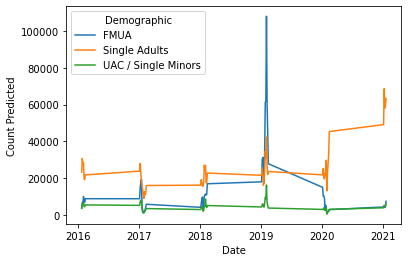

In [17]:
# this plot shows the predicted counts for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="Count Predicted",hue="Demographic")

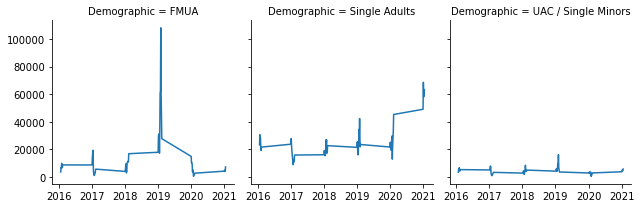

In [18]:
# these graphs are the same as the previous one, the predicted counts for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="Date",y="Count Predicted")

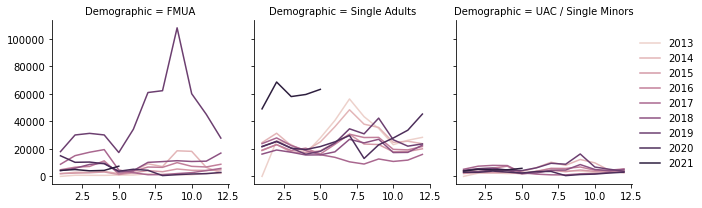

In [19]:
# These graphs show the month-to-month predicted counts for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
g = sns.FacetGrid(graph_df, col="Demographic") 
g.map_dataframe(sns.lineplot,x="M",y="Count Predicted",hue="FY",legend='full')
g.add_legend()

### Plots of the  Percent Change each Month

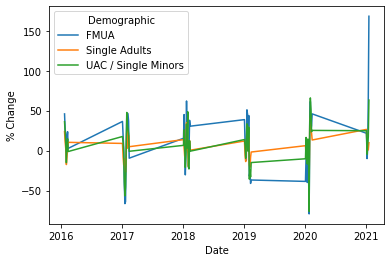

In [20]:
# this plot shows the percent change for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="% Change",hue="Demographic")

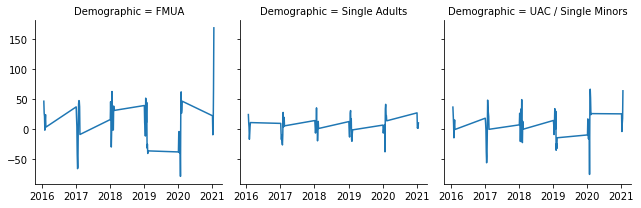

In [21]:
# these graphs are the same as the previous one, the percent change for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="Date",y="% Change")

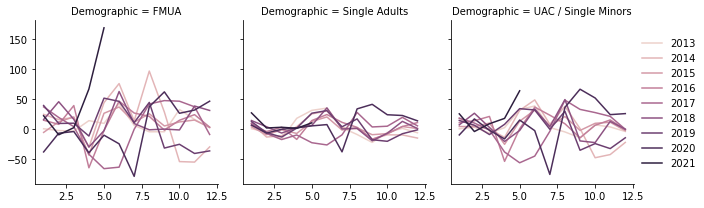

In [22]:
# These graphs show the month-to-month percent changes for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="M",y="% Change",hue="FY",legend='full')
g.add_legend()

### Different Plots of Error each Month

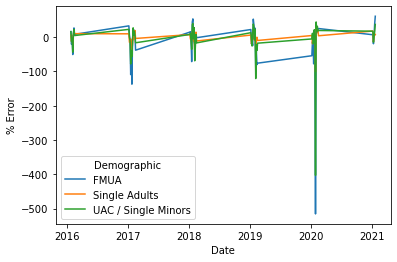

In [23]:
# this plot shows the error calculation for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="% Error",hue="Demographic")

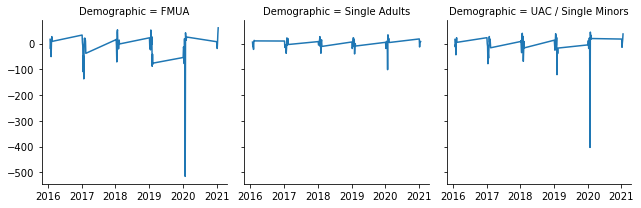

In [24]:
# these graphs are the same as the previous one, the error calculation for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="Date",y="% Error")

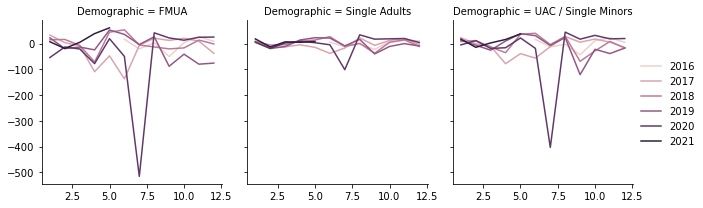

In [26]:
# These graphs show the month-to-month error calculation for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
g = sns.FacetGrid(graph_df, col="Demographic")
g.map_dataframe(sns.lineplot,x="M",y="% Error",hue="FY",legend='full')
g.add_legend()

### Plots of the Actual and Predicted Counts by Demographic and Year

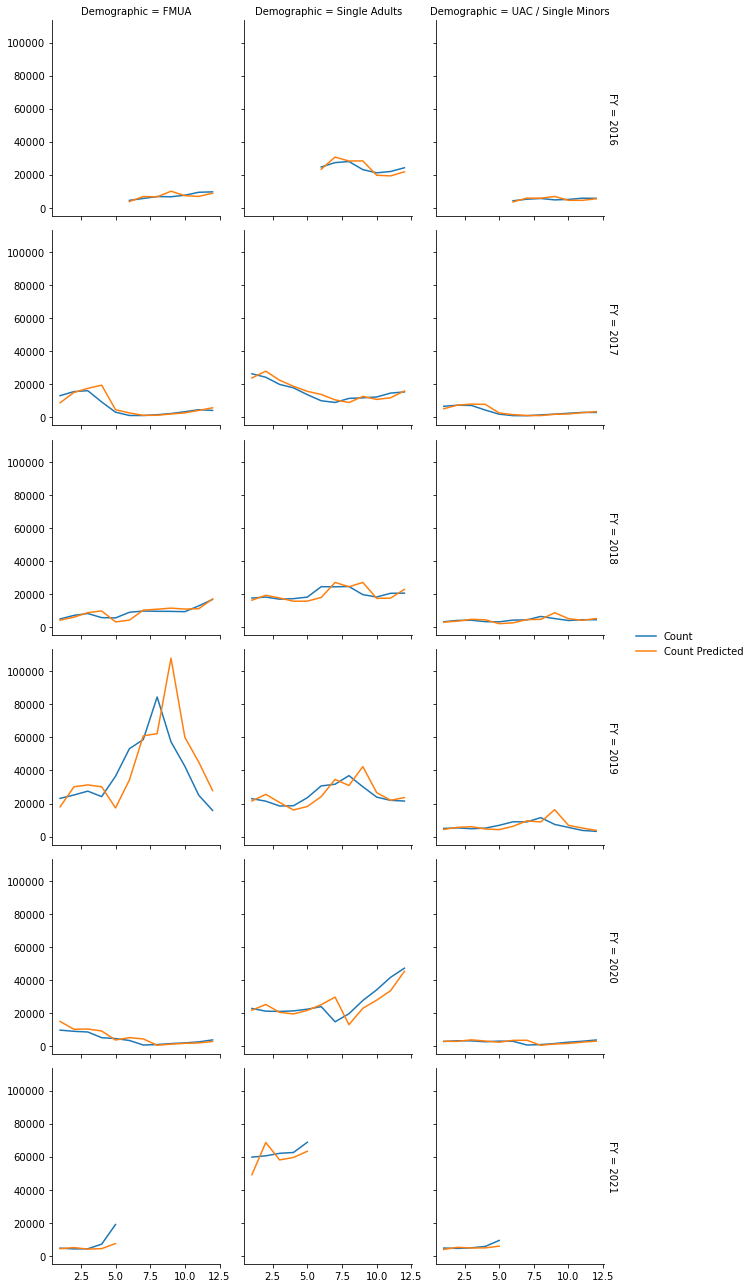

In [27]:
# the following graphs show the count in blue and the predicted count in orange.  We can see how
# good the predictions were based on how close the lines are together.  The x-axis has the months
# represented by their numerical value, and the y axis has the counts.  Each row of graphs
# represents a different fiscal year, and each column represents a different demographic.
melted_df = pd.melt(graph_df, id_vars=['Demographic','FY','M'], value_vars=['Count', 'Count Predicted'])
g = sns.FacetGrid(melted_df, col="Demographic", row="FY",margin_titles=True)
g = g.map_dataframe(sns.lineplot,x="M",y="value",hue="variable")
g.add_legend()